# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.5.1


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [13]:
class ChesXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.endswith('png')]
            print(f'Found {len(images)} in {class_name}.')
            return images
        
        self.class_names = ['normal','viral','covid']
        self.images = {c:get_images(c) for c in self.class_names}

        self.image_dirs = image_dirs
        self.transform = transform
    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

# Prepare DataLoader

In [14]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChesXRayDataset(train_dirs, train_transform)

Found 1311 in normal.
Found 1315 in viral.
Found 189 in covid.


In [15]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}
test_dataset = ChesXRayDataset(test_dirs, test_transform)

Found 30 in normal.
Found 30 in viral.
Found 30 in covid.


In [16]:
batch_size = 6

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size, 
                                             shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size,
                                            shuffle=True)

print('Number of training batches:', len(train_data_loader))
print('Number of testing batches:', len(test_data_loader))

Number of training batches: 470
Number of testing batches: 15


# Data Visualization

In [33]:
class_names = train_dataset.class_names

# in the resnet pytorch implementation the channel comes first so we have to transpose it
# to show it on matplot
def show_images(images, labels, preds):
    plt.figure(figsize=(10,4))
    
    for i, image in enumerate(images):
        plt.subplot(1,6,i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1,2,0))
        # since we normilzed the images we have to reverse it
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = image * (std + mean)
        image = np.clip(image, 0.,1)
        plt.imshow(image)
        col = 'green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

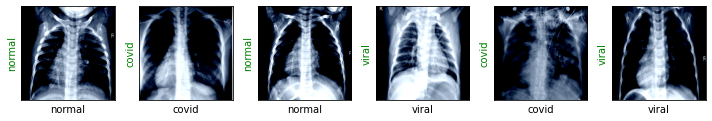

In [27]:
IMAGES , LABELS = next(iter(train_data_loader))
show_images(IMAGES, LABELS, LABELS)

# Creating the Model

In [28]:
resnet = torchvision.models.resnet18(pretrained=True)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
resnet.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(resnet.parameters(), lr=3e-5)

In [31]:
def show_pred():
    resnet.eval()
    images, labels = next(iter(test_data_loader))
    out = resnet(images)
    _, preds = torch.max(out, 1)
    show_images(images, labels, preds)

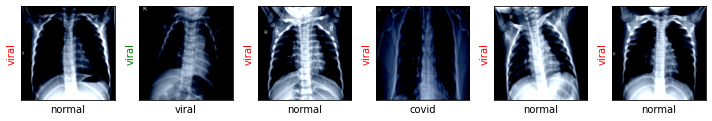

In [34]:
show_pred()

# Training the Model

In [37]:
def train(epochs):
    print('Starting training...')
    for e in range(0,epochs):
        print("="*25)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*25)
        train_loss = 0
        resnet.train()
        
        for train_step, (images, labels) in enumerate(train_data_loader):
            OPTIMIZER.zero_grad()
            outputs = resnet(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            OPTIMIZER.step()
            train_loss += loss.item()
            if train_step % 20 ==0:
                print('Evaluating AT step:', train_step)
                acc = 0
                val_loss = 0
                resnet.eval()
                for val_step, (imgs, labls) in enumerate(test_data_loader):
                    out = resnet(imgs)
                    loss = loss_fn(out, labls)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(out, 1)
                    acc += sum((preds==labls).numpy())
                val_loss /= (val_step+1)
                acc = acc / len(test_dataset)
                print(f'val loss: {val_loss:.4f}, acc: {acc:.4f}')
                show_pred()
                resnet.train()
                
                if acc > 0.95:
                    print(f'accuracy exceded 0.95%.. ending the training.')
                    return
            train_loss /= (train_step+1)
            print(f'training loss: {train_loss:.4f}')
            

Starting training...
Starting epoch 1/1
Evaluating AT step: 0
val loss: 1.0506, acc: 0.4778


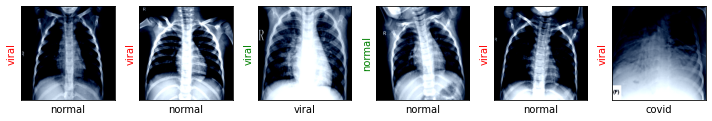

training loss: 1.0616
training loss: 0.9802
training loss: 0.5787
training loss: 0.4019
training loss: 0.2826
training loss: 0.1588
training loss: 0.1948
training loss: 0.1054
training loss: 0.1405
training loss: 0.0686
training loss: 0.0747
training loss: 0.0449
training loss: 0.0609
training loss: 0.0423
training loss: 0.0331
training loss: 0.0603
training loss: 0.0277
training loss: 0.0360
training loss: 0.0451
training loss: 0.0217
Evaluating AT step: 20
val loss: 0.5226, acc: 0.9111


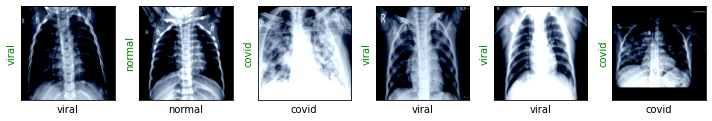

training loss: 0.0344
training loss: 0.0247
training loss: 0.0250
training loss: 0.0189
training loss: 0.0271
training loss: 0.0251
training loss: 0.0246
training loss: 0.0163
training loss: 0.0227
training loss: 0.0227
training loss: 0.0158
training loss: 0.0098
training loss: 0.0069
training loss: 0.0217
training loss: 0.0083
training loss: 0.0086
training loss: 0.0148
training loss: 0.0127
training loss: 0.0095
training loss: 0.0076
Evaluating AT step: 40
val loss: 0.2705, acc: 0.9333


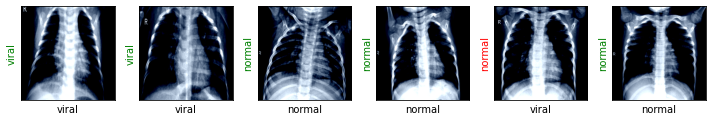

training loss: 0.0108
training loss: 0.0150
training loss: 0.0052
training loss: 0.0071
training loss: 0.0086
training loss: 0.0028
training loss: 0.0039
training loss: 0.0050
training loss: 0.0094
training loss: 0.0053
training loss: 0.0051
training loss: 0.0036
training loss: 0.0117
training loss: 0.0082
training loss: 0.0015
training loss: 0.0050
training loss: 0.0042
training loss: 0.0021
training loss: 0.0057
training loss: 0.0046
Evaluating AT step: 60
val loss: 0.2672, acc: 0.8778


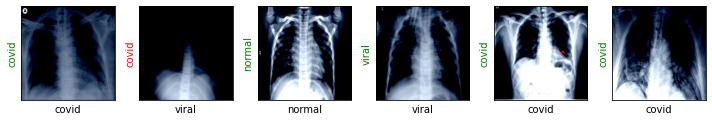

training loss: 0.0139
training loss: 0.0027
training loss: 0.0068
training loss: 0.0013
training loss: 0.0051
training loss: 0.0013
training loss: 0.0019
training loss: 0.0008
training loss: 0.0009
training loss: 0.0019
training loss: 0.0072
training loss: 0.0027
training loss: 0.0010
training loss: 0.0028
training loss: 0.0011
training loss: 0.0081
training loss: 0.0024
training loss: 0.0025
training loss: 0.0013
training loss: 0.0011
Evaluating AT step: 80
val loss: 0.1883, acc: 0.9556


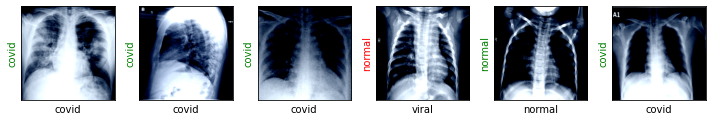

accuracy exceded 0.95%.. ending the training.


In [38]:
train(1)

# Final Results

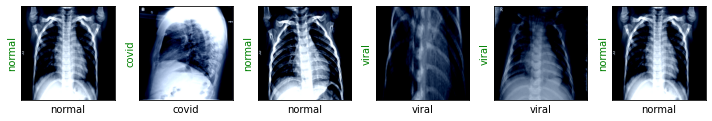

In [40]:
show_pred()

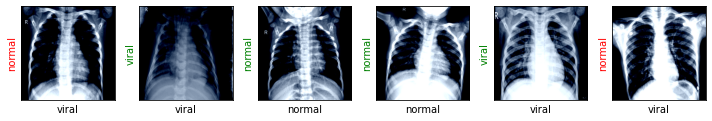

In [41]:
show_pred()